In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(37) # 使得每次运行得到的随机数都一样

In [2]:
# 准备数据集
data_path='E:\PyProjects\DataSet\FireAI/data_perf.txt'
df=pd.read_csv(data_path,header=None)
print(df.info()) # 查看数据信息，确保没有错误
# print('-'*100)
dataset=df.values # 数据加载没有问题
# print(dataset.shape) # (250, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
0    250 non-null float64
1    250 non-null float64
dtypes: float64(2)
memory usage: 4.0 KB
None


In [3]:
# 定义一个DBCSCAN模型，并用数据集训练它
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=0.5,min_samples=5) # 此处的参数是随便指定
model.fit(dataset)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [4]:
# 使用轮廓系数评估模型的优虐
from sklearn.metrics import silhouette_score
si_score=silhouette_score(dataset,model.labels_)
print('si_score: {:.4f}'.format(si_score))

si_score: 0.5134


In [5]:
# 在定义DBSCAN时，往往我们很难知道最优的eps参数，
# 故而可以通过遍历得到最优值
def get_optimal_eps(dataset,eps_list):
    '''get optimal eps param for DBSCAN 
       params: 
            dataset: the whole dataset.
            eps_list: must be in np.linspace() format or list format.
        return:
            three values：optimal eps value, 
                optimal model with optimal eps
                silhouette_scores of all candidate eps.
        '''
    scores=[]
    models=[]
    for eps in eps_list:
        model=DBSCAN(eps=eps,min_samples=5).fit(dataset)
        labels=model.labels_
        label_num=len(np.unique(labels))
        if label_num>1: # 需要判断label种类，因为如果只有一个label，silhouette_score报错
            scores.append(silhouette_score(dataset,model.labels_))
            models.append(model)
        else:
            scores.append(0)
            models.append(None)
    optimal_id=scores.index(max(scores))
    return eps_list[optimal_id],models[optimal_id],scores

In [6]:
optimal_eps, optimal_model,scores=get_optimal_eps(dataset,np.linspace(0.3, 1.7, num=15))
print('optimal eps: {:.4f}, \ncandidate eps: {}, \nscores: {}'.format(optimal_eps,np.linspace(0.3,1.7,15),scores))

optimal eps: 0.8000, 
candidate eps: [0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7], 
scores: [0.12865164017329436, 0.3593618148137507, 0.5134143263329637, 0.616532168834258, 0.6321600450689241, 0.6366395861050828, 0.5141678956134529, 0.5629298661962946, 0.5629298661962946, 0.5629298661962946, 0, 0, 0, 0, 0]


In [7]:
# 上述函数得到了最佳eps参数和该最佳参数下的最佳模型，我们可以从该最佳模型中得到一些属性
labels=optimal_model.labels_
label_num=len(np.unique(labels))
# 但是有标记为-1的样本
# 这些样本是没有分配集群的样本，被认为是异常点。
if -1 in labels:
    label_num-=1 # 需要减一个类别，减去异常点
print('clusters num: ',label_num) # 最佳模型划分的簇群数量，


# print(labels)
# DBSCAN模型中可以得到核心样本的数据点坐标
# 首先获取核心样本的坐标索引
core_index=optimal_model.core_sample_indices_
# print(core_index)
mask_core=np.zeros(labels.shape,dtype=np.bool)
mask_core[model.core_sample_indices_]=True
# print(mask_core)

clusters num:  5


In [8]:
def visual_2D_dataset(dataset_X,dataset_y):
        '''将二维数据集dataset_X和对应的类别dataset_y显示在散点图中'''
        assert dataset_X.shape[1]==2,'only support dataset with 2 features'
        classes=list(set(dataset_y)) 
        markers=['.',',','o','v','^','<','>','1','2','3','4','8'
                 ,'s','p','*','h','H','+','x','D','d','|']
        # colors=['b','c','g','k','m','w','r','y']
        colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        plt.figure()
        for class_id in classes:
            one_class=np.array([feature for (feature,label) in 
                       zip(dataset_X,dataset_y) if label==class_id])
            plt.scatter(one_class[:,0],one_class[:,1],marker=markers[class_id%len(markers)],
                        c=colors[class_id%len(colors)],label='class_'+str(class_id))
        plt.legend()

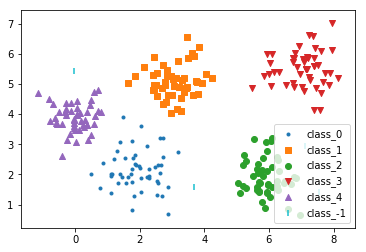

In [9]:
visual_2D_dataset(dataset,labels)